<a href="https://colab.research.google.com/github/saranyakarthi4/BigMountain-Ski-Resort---Pricing-Strategy---Regression/blob/master/VIYR_OPS_Revenue_Forecast_Monte_Carlo_Simulation_Stat_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement : For my feature View in Your Room in Amazon App, we have
1) Last 2 years monthly customer visits(avg monthly is 1.5B visits)
2) last 2 years monthly OPS data(avg monthly OPS is ~$120MM, highly monthly sensitive)
3) last 24 months customer Click-through rate(~6%),
4) last 24 months customer conversion rate (avg monthly conversion rate from VIYR is 5%)
5) last 24 months monthly 3D model coverage (recently at 35%).

Based on all this data points, we are forecasting next 12 months OPS using 'Seasonality aware- Monte Carlo Simulations' method

Monthly OPS = Monthly Visits × VIYR CTR × 3D Coverage × Conversion Rate × ASP(AOV)
Monthly OPS = 1,500,000,000.00,0.06,0.35,0.05,90 =$141.7MM


**Section 1 – Synthetic Historical Data**
Generates synthetic data matching your described statistics (replace with your real CSVs). Visits and OPS are given a seasonal wave + trend. Adoption, CVR, and Coverage are created for the last 24 months.

**Section 2: **

**Fitting Distributions**
Each driver gets a statistically appropriate distribution:
1) Visits - Lognormal - Always positive, right-skewed, multiplicative noise

2) CTR - BetaBounded [0,1] - flexible shape

3) Conversion Rate - Beta[0,1]

4) 3D Model Coverage - Linear trend + Gaussian noise - It's a ramp, not stationary

5) AOV- Lognormal - Back-calculated; always positive, right

For Visits, the data is de-seasonalised and de-trended first before fitting, so the σ captures pure random noise — not seasonal variance getting baked into uncertainty.

**Section 3 – The Simulation Loop (Core Logic)**
For each of the 12 forecast months:

1) Seasonality is applied by shifting the lognormal mean by ln(seasonality_index) for visits and AOV, and scaling the Beta mean for CVR. This means November/December samples are drawn from a fundamentally higher distribution, not just shifted after the fact.
2) Trend is extrapolated — visits continue their historical +0.3%/month; 3D coverage continues its linear ramp (35% → ~43% by Dec).
3) CTR adds a small +0.05pp improvement every 6 months as the feature matures.

4) 10,000 samples are drawn from each driver, multiplied together, giving 10,000 OPS scenarios per month.


P10/P50/P90 summarise the distribution.

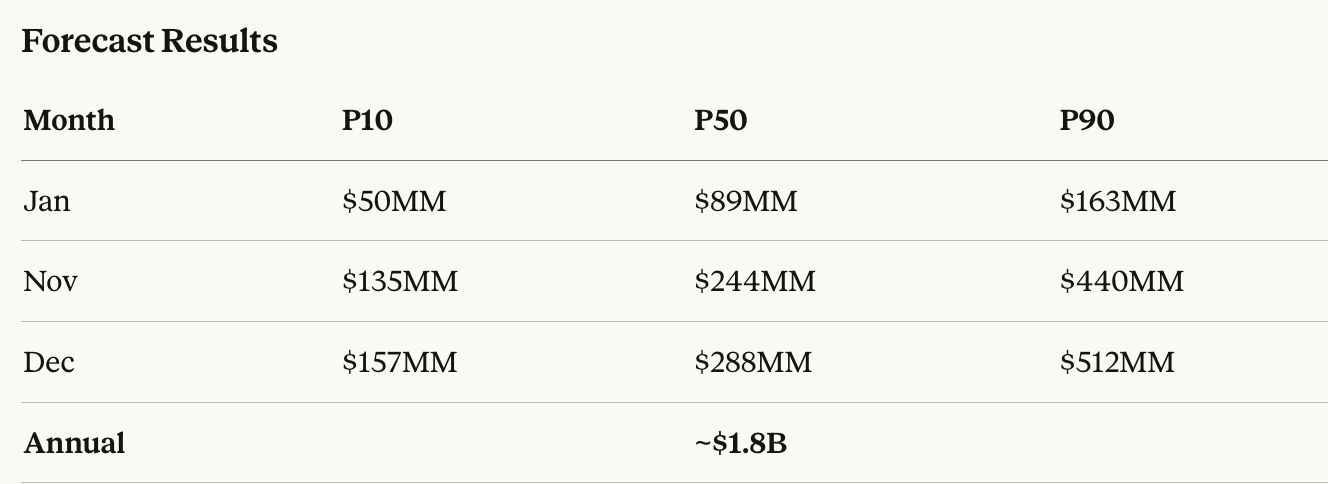

In [ ]:
The above image shows Monte Carlo simulations for each month OPS ranges. P10 means 10% of simulated data is lower than $50MM for Jan.

"""
=============================================================================
Amazon "View in Your Room" (VIYR) – Seasonality-Aware Monte Carlo OPS Forecast
=============================================================================

BUSINESS CONTEXT
----------------
OPS (Ordered Product Sales) for VIYR flows through this causal chain:

  Customer Visits
       × Adoption Rate      (% of visitors who tap "View in Your Room")
       × 3D Model Coverage   (% of products that have a 3D model available)
       × Conversion Rate     (% of VIYR sessions that result in a purchase)
       × Average Order Value (implied: OPS / (Visits × Adoption × Coverage × CVR))
  ──────────────────────────────────────────────────────────────────────────
  = OPS

Monte Carlo works by:
  1. Fitting probability distributions to each driver from historical data.
  2. Sampling 10,000 random "futures" per month.
  3. Multiplying the sampled drivers together each time.
  4. Summarising the resulting OPS distribution (P10 / median / P90).

Seasonality is injected by scaling the base-level mean of each driver by
that month's seasonality index BEFORE drawing random samples.
=============================================================================
"""

In [6]:
"""
=============================================================================
Amazon "View in Your Room" (VIYR) – Seasonality-Aware Monte Carlo OPS Forecast
=============================================================================

BUSINESS CONTEXT
----------------
OPS (Ordered Product Sales) for VIYR flows through this causal chain:

  Customer Visits
       × Adoption Rate      (% of visitors who tap "View in Your Room")
       × 3D Model Coverage   (% of products that have a 3D model available)
       × Conversion Rate     (% of VIYR sessions that result in a purchase)
       × Average Order Value (implied: OPS / (Visits × Adoption × Coverage × CVR))
  ──────────────────────────────────────────────────────────────────────────
  = OPS

Monte Carlo works by:
  1. Fitting probability distributions to each driver from historical data.
  2. Sampling 10,000 random "futures" per month.
  3. Multiplying the sampled drivers together each time.
  4. Summarising the resulting OPS distribution (P10 / median / P90).

Seasonality is injected by scaling the base-level mean of each driver by
that month's seasonality index BEFORE drawing random samples.
=============================================================================
"""

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)           # reproducibility

In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 1 – SYNTHETIC HISTORICAL DATA
# (Replace these arrays with your real CSV / DataFrame reads)
# ─────────────────────────────────────────────────────────────────────────────

# 1-A  60 months of Customer Visits (millions).  Average ≈ 12 MM.
#      We bake in a realistic seasonal wave and gentle upward trend.
months_24 = np.arange(24)    # month index 0 … 23 for 2 years
# o/p : array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
#      17, 18, 19, 20, 21, 22, 23])

In [ ]:
# *********** DO NOT RUN THIS SECTION *********************

# # We could use sine waves if we observe spikes for any particular months
# Dual-peak seasonal pattern: Prime Day (July) + Holiday season (Nov/Dec)

#
# For example We combine TWO sine waves — one for each business event:
#
#  Wave 1 – Holiday peak (Nov/Dec):
#    Amplitude = 0.35  → visits swing up to +35% in Nov/Dec
#    Phase shift = -9  → sine peaks at calendar month index 9+3=12 ≈ December
#
#  Wave 2 – Prime Day peak (July):
#    Amplitude = 0.18  → smaller secondary bump, up to +18% in July
#    Phase shift = -3  → sine peaks at calendar month index 3+3=6 ≈ July
#
#  Adding them together creates a waveform with two humps per year.
#  The amplitudes are different because Holiday >> Prime Day for VIYR.
#  Adjust 0.35 and 0.18 to match the actual lift % you see in your data.

#cal_month_24  = months_24 % 12                    # 0=Jan … 11=Dec each year

#holiday_wave  = 0.35 * np.sin(2 * np.pi * (cal_month_24 - 9) / 12)
# 0.35  → holiday season lifts visits ~35% above average
# -9    → shifts the sine peak to December (month index 11)

#prime_day_wave = 0.18 * np.sin(2 * np.pi * (cal_month_24 - 3) / 12)
# 0.18  → Prime Day lifts visits ~18% above average (secondary peak)
# -3    → shifts the sine peak to July (month index 6)

#seasonal_wave = 1 + holiday_wave + prime_day_wave
# Result: seasonal multiplier > 1 in Jul, Nov, Dec; dips below 1 in Jan-Feb, Sep

#trend         = 1 + 0.003 * months_60                 # +0.3 % per month
#visits_hist   = (12.0 * seasonal_wave * trend          # base 12 MM
                 * np.random.lognormal(0, 0.05, 60))   # random noise ±5%

# 1-B  60 months of OPS ($MM).  Average ≈ $90 MM; highly seasonal.
# OPS seasonality is stronger than visits (higher AOV + CVR in peak months).
# Same dual-peak logic; holiday amplitude raised to 0.55, Prime Day to 0.25.
#ops_holiday   = 0.55 * np.sin(2 * np.pi * (cal_month_60 - 9) / 12)
#ops_prime_day = 0.25 * np.sin(2 * np.pi * (cal_month_60 - 3) / 12)
#ops_seasonal  = 1 + ops_holiday + ops_prime_day
#ops_hist      = (90.0 * ops_seasonal * trend
                 * np.random.lognormal(0, 0.08, 60))

# 1-C  Last 24 months of Adoption Rate (~5 %).
#adoption_hist = np.clip(
    np.random.normal(0.05, 0.004, 24), 0.02, 0.12)

# 1-D  Last 24 months of Conversion Rate (~3 %).
#cvr_hist      = np.clip(
    np.random.normal(0.03, 0.003, 24), 0.01, 0.08)

# 1-E  Last 24 months of 3-D Model Coverage (ending at 35 %).
#      Assume gradual ramp from ~20 % to 35 %.
#coverage_hist = np.clip(
    np.linspace(0.20, 0.35, 24) + np.random.normal(0, 0.01, 24), 0.10, 0.60)

# 1-F  Seasonality Index for each calendar month (Jan=0 … Dec=11).
#      Values > 1 are above-average months (Q4 = holiday peak).
#seasonality_index = np.array([
    0.70,   # Jan  – post-holiday dip; returns & low intent
    0.72,   # Feb  – still slow; slight Valentine's lift for home decor
    0.80,   # Mar  – spring refresh begins
    0.85,   # Apr  – steady ramp, spring shopping
    0.88,   # May  – Memorial Day / pre-summer
    0.92,   # Jun  – building toward Prime Day
    1.20,   # Jul  PEAK-1: Prime Day – biggest mid-year event; VIYR drives impulse buys
    0.90,   # Aug  – post-Prime Day cooldown
    0.88,   # Sep  – pre-holiday quiet
    1.05,   # Oct  – Prime Early Access / pre-holiday ramp
    1.38,   # Nov  PEAK-2: Black Friday / Cyber Monday
    1.52,   # Dec  PEAK-3: Christmas – highest OPS month
#])
# Normalise so annual average index = 1.0 → keeps P50 forecasts unbiased.
# Without this, the mean of all monthly forecasts would drift above/below $90MM baseline.
#seasonality_index = seasonality_index / seasonality_index.mean()

In [8]:
# ── VIYR-SPECIFIC SEASONAL MULTIPLIERS (directly specified per month) ────────
#
# Why we moved away from sine waves:
#   Sine waves are symmetric and can only model smooth, single-humped patterns.
#   VIYR has a highly ASYMMETRIC, business-driven shape:
#     - Spike  in July  (+25%) due to Prime Day AR feature promotion
#     - Spike  in Oct   (+10%) due to Prime Early Access Sale
#     - Spike  in Nov   (+18%) due to Thanksgiving / Black Friday deals
#     - DROP   in Dec   (-12%) because customers already bought furniture/decor
#                              during Thanksgiving deals; December is a cooldown
#
#   This shape CANNOT be captured by a sine wave. We instead define the exact
#   monthly multiplier for each calendar month directly as an array.
#
# How to read these numbers:
#   1.00 = exactly average (no seasonal effect)
#   1.25 = 25% ABOVE average  (July Prime Day spike)
#   0.88 = 12% BELOW average  (December post-Thanksgiving drop)
#
# Visits multipliers (affects customer traffic):
# It is a seasonal index — it tells you how each month compares to the annual average month, not how it compares to the previous month.
visits_monthly_multiplier = np.array([
    0.99,   # Jan  – post-holiday fatigue; low home-decor intent
    0.80,   # Feb  – still slow; some Valentine's Day home gifting
    0.85,   # Mar  – spring refresh starts; gradual ramp
    0.90,   # Apr  – steady growth; spring home improvement
    0.92,   # May  – Memorial Day weekend bump; patio furniture
    0.85,   # Jun  – pre-Prime Day awareness building
    1.25,   # Jul  ▲ SPIKE +25%: Prime Day — VIYR prominently featured;
            #         AR try-before-you-buy drives massive impulse visits
    0.92,   # Aug  – post-Prime Day cooldown; back-to-school distraction
    0.85,   # Sep  – quiet period; customers waiting for holiday deals
    1.10,   # Oct  ▲ SPIKE +10%: Prime Early Access Sale + Halloween decor
    1.18,   # Nov  ▲ SPIKE +18%: Thanksgiving deals + Black Friday;
            #         customers actively shopping furniture & home decor via AR
    0.88,   # Dec  ▼ DROP  -12%: post-Thanksgiving cooldown; big purchases
            #         already made; remaining Dec traffic is gifts, not furniture
])
# visits_monthly_multiplier
# O/P : array([0.99, 0.8 , 0.85, 0.9 , 0.92, 0.85, 1.25, 0.92, 0.85, 1.1 , 1.18,
#       0.88])
# Normalise so the 12-month average multiplier = 1.0
# This ensures the annual OPS forecast stays anchored to the $90MM monthly baseline.
# Without normalisation, the mean would drift and compound errors over 12 months.
visits_monthly_multiplier = (visits_monthly_multiplier
                             / visits_monthly_multiplier.mean())
visits_monthly_multiplier
# O/P : array([1.03394256, 0.83550914, 0.88772846, 0.93994778, 0.96083551,
#       0.88772846, 1.30548303, 0.96083551, 0.88772846, 1.14882507,
#      1.23237598, 0.91906005])

array([1.03394256, 0.83550914, 0.88772846, 0.93994778, 0.96083551,
       0.88772846, 1.30548303, 0.96083551, 0.88772846, 1.14882507,
       1.23237598, 0.91906005])

In [9]:
# OPS multipliers (stronger seasonal swings than visits because AOV + CVR also peak):
# During Prime Day and Nov, not only do more people visit — they also convert at
# higher rates and buy bigger-ticket items. So OPS spikes are amplified vs visits.
# December drop is also deeper for OPS: low-intent browsers don't convert.
ops_monthly_multiplier = np.array([
    0.96,   # Jan
    0.85,   # Feb
    0.82,   # Mar
    0.88,   # Apr
    0.90,   # May
    0.90,   # Jun
    1.35,   # Jul  ▲ SPIKE: Prime Day OPS lifts more than visits (+35%)
            #         because CVR spikes due to deal urgency + AR engagement
    0.90,   # Aug
    0.88,   # Sep
    1.12,   # Oct  ▲ SPIKE: Early Access Sale drives considered purchases
    1.28,   # Nov  ▲ SPIKE: Thanksgiving week is highest-intent buying period
    0.82,   # Dec  ▼ DROP: Steeper OPS drop than visits — browsers don't buy;
            #         gift-focused traffic has low AR-to-purchase conversion
])
ops_monthly_multiplier = ops_monthly_multiplier / ops_monthly_multiplier.mean()

In [10]:
# Apply multipliers to generate 24 months of history
# months_24 % 12 converts absolute month index (0-23) to calendar month (0-11)
cal_month_24  = months_24 % 12
cal_month_24
# o/p : array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,
#       5,  6,  7,  8,  9, 10, 11])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11])

In [11]:
# Look up the seasonal multiplier for each of the 24 historical months
visits_seasonal = visits_monthly_multiplier[cal_month_24]
ops_seasonal    = ops_monthly_multiplier[cal_month_24]

trend         = 1 + 0.003 * months_24                 # +0.3% per month growth
visits_hist   = (12.0 * visits_seasonal * trend         # base 12 MM × season × trend
                 * np.random.lognormal(0, 0.05, 24))    # ±5% random noise


In [12]:
# 1-B  60 months of OPS ($MM).  Average ≈ $90 MM; highly seasonal.
ops_hist      = (90.0 * ops_seasonal * trend
                 * np.random.lognormal(0, 0.08, 24))    # ±8% noise (OPS noisier than visits)


In [13]:
# 1-C  Last 24 months of Adoption Rate (~5 %), variance of 0.004, lower range is 4%, max range: 6%
adoption_hist = np.clip(np.random.normal(0.05, 0.004, 24), 0.04, 0.06)
adoption_hist

array([0.05137447, 0.04294784, 0.05129634, 0.04845967, 0.04729231,
       0.05244671, 0.054124  , 0.05372512, 0.04664313, 0.04876315,
       0.05132505, 0.05390218, 0.0480833 , 0.04925736, 0.04557466,
       0.04521517, 0.0532501 , 0.05542496, 0.04971196, 0.05401413,
       0.05144654, 0.04741952, 0.05144558, 0.05615215])

In [14]:
# 1-D  Last 24 months of Conversion Rate (~3 %), variance of 0.003, lower range is 2.5%, max range: 4%
cvr_hist      = np.clip(np.random.normal(0.03, 0.003, 24), 0.025, 0.04)
cvr_hist

array([0.02989252, 0.03469393, 0.025     , 0.03246571, 0.03026114,
       0.02910298, 0.03027528, 0.025     , 0.02934098, 0.03107134,
       0.03443368, 0.02844519, 0.02757452, 0.02849473, 0.03274621,
       0.03098625, 0.02841072, 0.0315398 , 0.03029123, 0.03290593,
       0.02789384, 0.02901701, 0.02882368, 0.02560946])

In [15]:
# 1-E  Last 24 months of 3-D Model Coverage (ending at 30%).
#      Assume gradual ramp from ~27% to 40%.
coverage_hist = np.clip(np.linspace(0.30, 0.40, 24) + np.random.normal(0, 0.01, 24), 0.27, 0.40)
coverage_hist

array([0.3029612 , 0.30695838, 0.30874679, 0.31069761, 0.3032376 ,
       0.31753268, 0.32265981, 0.32241201, 0.33316975, 0.34317094,
       0.36234012, 0.34957187, 0.35474942, 0.35577728, 0.34168185,
       0.36495225, 0.37016752, 0.39854546, 0.37633726, 0.38562417,
       0.3866094 , 0.37961757, 0.4       , 0.4       ])

In [16]:
# 1-F  Seasonality Index for each calendar month (Jan=0 … Dec=11).
#      This index is used in Section 3 to scale the Monte Carlo sampling means.
#      It must match the business pattern defined in visits_monthly_multiplier above:
#        Jul  = +25% spike  (Prime Day)
#        Oct  = +10% spike  (Early Access Sale)
#        Nov  = +18% spike  (Thanksgiving / Black Friday)
#        Dec  = -12% drop   (post-Thanksgiving cooldown)
#
#      NOTE: These are the RAW values before normalisation.
#      We normalise below so the 12-month average = 1.0 (unbiased baseline).
seasonality_index = np.array([
    0.99,   # Jan
    0.80,   # Feb  – slow; minor Valentine's lift
    0.85,   # Mar  – spring ramp begins
    0.90,   # Apr  – spring home improvement
    0.92,   # May  – Memorial Day patio/outdoor
    0.92,   # Jun  – pre-Prime Day buildup
    1.25,   # Jul  ▲ +25% Prime Day spike
    0.92,   # Aug  – cooldown after Prime Day
    0.90,   # Sep  – quiet pre-holiday lull
    1.10,   # Oct  ▲ +10% Early Access Sale
    1.18,   # Nov  ▲ +18% Thanksgiving / Black Friday
    0.88,   # Dec  ▼ -12% post-Thanksgiving drop
])
# Normalise: divide every value by the 12-month average.
# Example: if raw average = 0.952, then Jul becomes 1.25/0.952 = 1.313
# This ensures the annual average index = exactly 1.0 → no systematic bias.
seasonality_index = seasonality_index / seasonality_index.mean()
seasonality_index

array([1.02325581, 0.82687339, 0.87855297, 0.93023256, 0.95090439,
       0.95090439, 1.29198966, 0.95090439, 0.93023256, 1.1369509 ,
       1.21963824, 0.90956072])

In [17]:
print("\nNormalised Seasonality Index (1.0 = average month):")
month_names = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]
for name, idx in zip(month_names, seasonality_index):
    bar   = "▲" if idx > 1 else ("▼" if idx < 0.95 else " ")
    delta = (idx - 1) * 100
    print(f"  {name}: {idx:.3f}  {bar} ({delta:+.1f}% vs average)")

print("=" * 70)
print("VIYR OPS Forecast – Seasonality-Aware Monte Carlo Simulation")
print("=" * 70)


Normalised Seasonality Index (1.0 = average month):
  Jan: 1.023  ▲ (+2.3% vs average)
  Feb: 0.827  ▼ (-17.3% vs average)
  Mar: 0.879  ▼ (-12.1% vs average)
  Apr: 0.930  ▼ (-7.0% vs average)
  May: 0.951    (-4.9% vs average)
  Jun: 0.951    (-4.9% vs average)
  Jul: 1.292  ▲ (+29.2% vs average)
  Aug: 0.951    (-4.9% vs average)
  Sep: 0.930  ▼ (-7.0% vs average)
  Oct: 1.137  ▲ (+13.7% vs average)
  Nov: 1.220  ▲ (+22.0% vs average)
  Dec: 0.910  ▼ (-9.0% vs average)
VIYR OPS Forecast – Seasonality-Aware Monte Carlo Simulation


In [18]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2 – FIT DISTRIBUTIONS TO HISTORICAL DRIVERS
# ─────────────────────────────────────────────────────────────────────────────
# We fit each driver independently and store the parameters.
# Using lognormal for Visits / AOV (always positive, right-skewed).
# Using beta for rates (bounded 0-1).

# --- Visits: fit lognormal -----------------------------------------------
# De-trend and de-seasonalise before fitting so the noise is stationary.
month_idx_24  = np.arange(24)
seasonal_cal  = seasonality_index[month_idx_24 % 12]   # calendar season
trend_factor  = 1 + 0.003 * month_idx_24 # +0.3% mom growth factor

visits_deseasonalised = visits_hist / (seasonal_cal * trend_factor)
v_mu, v_sigma = (np.log(visits_deseasonalised).mean(),
                 np.log(visits_deseasonalised).std())
print(f"\nVisits lognormal fit  → μ={v_mu:.4f}, σ={v_sigma:.4f}")



Visits lognormal fit  → μ=2.4766, σ=0.0501


In [19]:
# --- Adoption Rate: fit beta ---------------------------------------------
# Method-of-moments for Beta distribution: estimate α and β from sample mean/var.
def fit_beta_mom(data):
    """Fit Beta(α, β) via method of moments."""
    # to fit into beta distribution find alpha and beta, alpha = m* k, beta = (1-m) * k, where k is total concentration which is k = alpha + beta
    # k = ( (m*(1-m))/var) - 1
    m  = data.mean()
    v  = data.var()
    v  = max(v, 1e-8)          # guard against zero variance, if. variance is 0 , then we are using 1e-8, very smallest number
    alpha = m * (m * (1 - m) / v - 1)
    beta  = (1 - m) * (m * (1 - m) / v - 1)
    return max(alpha, 0.1), max(beta, 0.1)

a_alpha, a_beta = fit_beta_mom(adoption_hist)
print(f"Adoption Beta fit     → α={a_alpha:.4f}, β={a_beta:.4f}")

Adoption Beta fit     → α=208.3586, β=3926.7820


In [20]:
# --- Conversion Rate: fit beta -------------------------------------------
c_alpha, c_beta = fit_beta_mom(cvr_hist)
print(f"Conversion Beta fit   → α={c_alpha:.4f}, β={c_beta:.4f}")

Conversion Beta fit   → α=130.9103, β=4267.7354


In [21]:
# --- 3-D Model Coverage: linear trend + noise ----------------------------
# Project the trend forward; the residuals set the uncertainty.
x_cov      = np.arange(len(coverage_hist))
slope, intercept, *_ = stats.linregress(x_cov, coverage_hist)
cov_resid  = coverage_hist - (intercept + slope * x_cov)
cov_resid_std = cov_resid.std()
print(f"Coverage trend        → slope={slope:.5f}/month, residual σ={cov_resid_std:.4f}")

Coverage trend        → slope=0.00447/month, residual σ=0.0087


In [22]:
# --- Average Order Value (AOV): back-calculate from OPS ----------------
# OPS = Visits × AdoptionRate × Coverage × CVR × AOV
#  ⟹  AOV = OPS / (Visits × Adoption × Coverage × CVR)
# We use the last 24 months where all four drivers overlap.
aov_hist = (ops_hist[-24:]
            / (visits_hist[-24:]
               * adoption_hist
               * coverage_hist
               * cvr_hist))
aov_mu, aov_sigma = np.log(aov_hist).mean(), np.log(aov_hist).std()
print(f"AOV lognormal fit     → μ={aov_mu:.4f}, σ={aov_sigma:.4f}")
print(f"  Implied AOV range   → ${np.exp(aov_mu - aov_sigma):.1f} – "
      f"${np.exp(aov_mu + aov_sigma):.1f}")

AOV lognormal fit     → μ=9.5600, σ=0.1333
  Implied AOV range   → $12415.1 – $16208.0


In [23]:
import numpy as np
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3 – MONTE CARLO SIMULATION FOR NEXT 12 MONTHS
# ─────────────────────────────────────────────────────────────────────────────
N_SIMS  = 10_000   # number of random scenarios per month
HORIZON = 12       # months to forecast

# The forecast window starts the month after the last historical observation.
# We assume history ends in Dec of the current year → forecast = next Jan … Dec.
last_hist_month_idx = 23          # 0-based index of the last observed month
future_month_indices = np.arange(last_hist_month_idx + 1,
    last_hist_month_idx + 1 + HORIZON)   # absolute month indices 60 … 71

# Calendar months (0=Jan … 11=Dec) for the forecast window.
# Adjust start_calendar_month to match your actual data end date.
start_calendar_month = 0          # January  (change if data ends mid-year)
forecast_calendar_months = [(start_calendar_month + m) % 12
                             for m in range(HORIZON)]

month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]

forecast_labels = [month_labels[m] for m in forecast_calendar_months]


In [27]:
future_month_indices, forecast_calendar_months, seasonality_index

(array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]),
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 array([1.02325581, 0.82687339, 0.87855297, 0.93023256, 0.95090439,
        0.95090439, 1.29198966, 0.95090439, 0.93023256, 1.1369509 ,
        1.21963824, 0.90956072]))

In [25]:

# Containers for simulation results
# np.clip(array, min, max) caps every value in an array so it stays within a specified range,
# if the array has any value < min, repalce with min, and if has any value > max, repalce with max

sim_results = []       # list of dicts, one per forecast month

print("\n" + "─" * 70)
print(f"Running {N_SIMS:,} Monte Carlo simulations × {HORIZON} months …")
print("─" * 70)

for step in range(HORIZON): # 12 months
    abs_idx     = future_month_indices[step]   # absolute month index
    cal_month   = forecast_calendar_months[step]
    s_idx       = seasonality_index[cal_month] # this month's seasonality index

    # ── 3-A  Trend factor for visits (continuation of historical trend) ──
    visits_trend = 1 + 0.003 * abs_idx        # same trend as historical fit 3% MoM Growth

    # ── 3-B  Sample Visits ──────────────────────────────────────────────
    # The lognormal was fit on de-seasonalised, de-trended data.
    # Multiply back by the seasonal index and trend to get absolute visits.
    visits_base  = np.exp(v_mu) * s_idx * visits_trend
    # Scale lognormal: if X ~ LogNormal(μ,σ), then c·X ~ LogNormal(μ+ln(c),σ)
    v_mu_adj     = np.log(visits_base)         # shift mean; σ unchanged
    visits_sim   = np.random.lognormal(v_mu_adj, v_sigma, N_SIMS)

    # ── 3-C  Sample Adoption Rate ────────────────────────────────────────
    # Slight upward drift assumed (+0.1 % per 6 months) as feature matures.
    adoption_drift = min(0.001 * (step // 6), 0.01)   # cap drift at +1pp
    # Shift Beta mean by re-parameterising with method of moments.
    new_adoption_mean = adoption_hist.mean() + adoption_drift
    new_adoption_mean = np.clip(new_adoption_mean, 0.04, 0.06) # min and max
    a_alpha_adj   = new_adoption_mean * (a_alpha + a_beta)
    a_beta_adj    = (1 - new_adoption_mean) * (a_alpha + a_beta)
    adoption_sim  = np.random.beta(a_alpha_adj, a_beta_adj, N_SIMS)

    # ── 3-D  Sample 3-D Model Coverage ──────────────────────────────────
    # Project forward along the fitted linear trend; add Gaussian noise.
    cov_step_idx  = len(coverage_hist) + step   # position on the trend line
    cov_mean      = np.clip(intercept + slope * cov_step_idx, 0.27, 0.40) # min and max
    coverage_sim  = np.clip(
        np.random.normal(cov_mean, cov_resid_std, N_SIMS), 0.27, 0.40)

    # ── 3-E  Sample Conversion Rate ──────────────────────────────────────
    # Apply seasonality: Q4 months historically have higher CVR.
    cvr_seasonal  = 1 + 0.10 * (s_idx - 1)    # mild season-lift on CVR
    cvr_mean_base = cvr_hist.mean() * cvr_seasonal
    c_alpha_adj   = cvr_mean_base * (c_alpha + c_beta)
    c_beta_adj    = (1 - cvr_mean_base) * (c_alpha + c_beta)
    c_alpha_adj   = max(c_alpha_adj, 0.1)
    c_beta_adj    = max(c_beta_adj, 0.1)
    cvr_sim       = np.random.beta(c_alpha_adj, c_beta_adj, N_SIMS)

    # ── 3-F  Sample AOV ──────────────────────────────────────────────────
    # AOV also has a mild seasonal lift (people spend more in Q4).
    aov_seasonal_adj = aov_mu + np.log(s_idx) * 0.15   # damped seasonal effect
    aov_sim          = np.random.lognormal(aov_seasonal_adj, aov_sigma, N_SIMS)

    # ── 3-G  Compute OPS for each simulation ────────────────────────────
    # OPS ($MM) = Visits(MM) × Adoption × Coverage × CVR × AOV($)
    # Note: Visits already in millions, AOV in dollars → result in $MM
    ops_sim = visits_sim * adoption_sim * coverage_sim * cvr_sim * aov_sim

    sim_results.append({
        "month":       forecast_labels[step],
        "cal_month":   cal_month,
        "s_idx":       s_idx,
        "ops_p10":     np.percentile(ops_sim, 10),
        "ops_p50":     np.percentile(ops_sim, 50),
        "ops_p90":     np.percentile(ops_sim, 90),
        "ops_mean":    ops_sim.mean(),
        "ops_std":     ops_sim.std(),
        "visits_p50":  np.percentile(visits_sim, 50),
        "adoption_p50":np.percentile(adoption_sim, 50),
        "coverage_p50":np.percentile(coverage_sim, 50),
        "cvr_p50":     np.percentile(cvr_sim, 50),
        "aov_p50":     np.percentile(aov_sim, 50),
    })

forecast_df = pd.DataFrame(sim_results)
forecast_df


──────────────────────────────────────────────────────────────────────
Running 10,000 Monte Carlo simulations × 12 months …
──────────────────────────────────────────────────────────────────────


,month,cal_month,s_idx,ops_p10,ops_p50,ops_p90,ops_mean,ops_std,visits_p50,adoption_p50,coverage_p50,cvr_p50,aov_p50
0,Jan,0,1.023256,89.152261,112.450202,141.850128,114.369430,20.881116,13.052944,0.050314,0.405822,0.029763,14216.559771
1,Feb,1,0.826873,69.518018,87.511765,110.378471,88.995070,16.231643,10.586277,0.050327,0.410398,0.029161,13749.954763
2,Mar,2,0.878553,75.921502,96.032331,120.335248,97.327173,17.724508,11.277811,0.050356,0.414681,0.029328,13896.045053
3,Apr,3,0.930233,82.457312,104.041442,131.508932,105.686720,19.347625,11.966598,0.050275,0.419292,0.029529,14016.552573
4,May,4,0.950904,86.003855,108.441458,136.670219,110.097149,19.978485,12.268863,0.050314,0.423599,0.029577,14028.988854
5,Jun,5,0.950904,86.969923,109.485786,138.140521,111.389860,20.145162,12.297412,0.050308,0.428067,0.029509,14064.457706
6,Jul,6,1.291990,133.244821,167.585499,210.769279,170.416968,30.863873,16.773054,0.051384,0.432652,0.030549,14789.324192
7,Aug,7,0.950904,91.141888,115.338054,145.479034,117.207145,21.319029,12.373797,0.051297,0.437129,0.029576,14055.259683
8,Sep,8,0.930233,90.153949,113.402847,142.747938,115.330177,21.112412,12.134809,0.051349,0.441462,0.029533,14010.273740
9,Oct,9,1.136951,116.987975,147.312291,185.619918,149.786046,27.065614,14.860271,0.051232,0.446142,0.030078,14464.149907


In [28]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 4 – RESULTS TABLE
# ─────────────────────────────────────────────────────────────────────────────
print("\n12-Month OPS Forecast ($MM) – Seasonality-Aware Monte Carlo")
print("─" * 70)
header = f"{'Month':<6} {'SeasonIdx':>10} {'P10 ($MM)':>10} "
header += f"{'P50 ($MM)':>10} {'P90 ($MM)':>10} {'Mean':>10} {'Std':>8}"
print(header)
print("─" * 70)
for _, r in forecast_df.iterrows():
    print(f"{r['month']:<6} {r['s_idx']:>10.2f} "
          f"{r['ops_p10']:>10.1f} {r['ops_p50']:>10.1f} "
          f"{r['ops_p90']:>10.1f} {r['ops_mean']:>10.1f} {r['ops_std']:>8.1f}")
print("─" * 70)
total_p50 = forecast_df["ops_p50"].sum()
print(f"{'Annual Total':>50}   {total_p50:>8.1f}")

print("\nKey driver medians (P50) per month:")
driver_cols = ["month","visits_p50","adoption_p50","coverage_p50","cvr_p50","aov_p50"]
driver_labels = ["Month","Visits(MM)","Adoption%","Coverage%","CVR%","AOV($)"]
print(f"{driver_labels[0]:<6}", end="")
for lbl in driver_labels[1:]:
    print(f"{lbl:>12}", end="")
print()
for _, r in forecast_df.iterrows():
    print(f"{r['month']:<6} {r['visits_p50']:>12.2f} "
          f"{r['adoption_p50']*100:>11.2f}% "
          f"{r['coverage_p50']*100:>11.2f}% "
          f"{r['cvr_p50']*100:>10.2f}% "
          f"{r['aov_p50']:>10.2f}")


12-Month OPS Forecast ($MM) – Seasonality-Aware Monte Carlo
──────────────────────────────────────────────────────────────────────
Month   SeasonIdx  P10 ($MM)  P50 ($MM)  P90 ($MM)       Mean      Std
──────────────────────────────────────────────────────────────────────
Jan          1.02       89.2      112.5      141.9      114.4     20.9
Feb          0.83       69.5       87.5      110.4       89.0     16.2
Mar          0.88       75.9       96.0      120.3       97.3     17.7
Apr          0.93       82.5      104.0      131.5      105.7     19.3
May          0.95       86.0      108.4      136.7      110.1     20.0
Jun          0.95       87.0      109.5      138.1      111.4     20.1
Jul          1.29      133.2      167.6      210.8      170.4     30.9
Aug          0.95       91.1      115.3      145.5      117.2     21.3
Sep          0.93       90.2      113.4      142.7      115.3     21.1
Oct          1.14      117.0      147.3      185.6      149.8     27.1
Nov          1.2


✓ Chart saved → viyr_ops_forecast.png


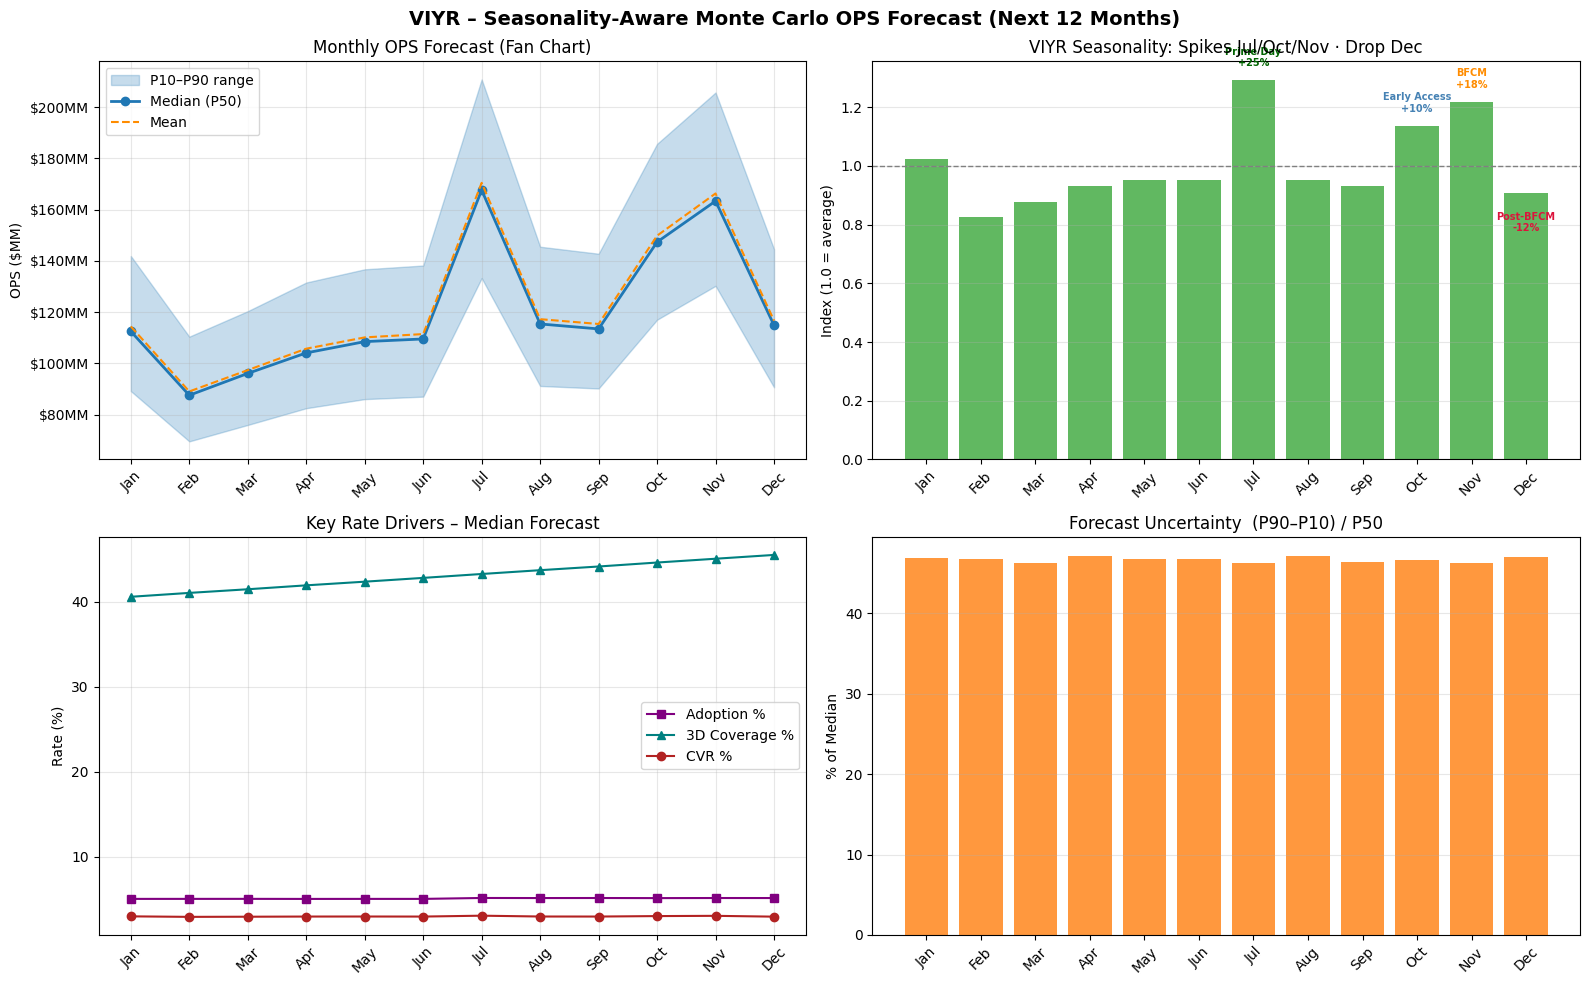

In [30]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 5 – VISUALISATION
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("VIYR – Seasonality-Aware Monte Carlo OPS Forecast (Next 12 Months)",
             fontsize=14, fontweight="bold")

# 5-A  Fan chart: P10-P90 band + median
ax = axes[0, 0]
x  = np.arange(HORIZON)
ax.fill_between(x, forecast_df["ops_p10"], forecast_df["ops_p90"],
                alpha=0.25, color="#1f77b4", label="P10–P90 range")
ax.plot(x, forecast_df["ops_p50"], "o-", color="#1f77b4",
        linewidth=2, markersize=6, label="Median (P50)")
ax.plot(x, forecast_df["ops_mean"], "--", color="darkorange",
        linewidth=1.5, label="Mean")
ax.set_xticks(x); ax.set_xticklabels(forecast_df["month"], rotation=45)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v,_: f"${v:.0f}MM"))
ax.set_title("Monthly OPS Forecast (Fan Chart)"); ax.set_ylabel("OPS ($MM)")
ax.legend(); ax.grid(alpha=0.3)

# 5-B  Seasonality index
ax = axes[0, 1]
ax.bar(x, forecast_df["s_idx"], color="#2ca02c", alpha=0.75)
ax.axhline(1.0, color="grey", linestyle="--", linewidth=1)
ax.set_xticks(x); ax.set_xticklabels(forecast_df["month"], rotation=45)
ax.set_title("VIYR Seasonality: Spikes Jul/Oct/Nov · Drop Dec"); ax.set_ylabel("Index (1.0 = average)")
# Annotate spikes and drop
for peak_m, label, color in [(6, "Prime Day\n+25%", "darkgreen"),
                               (9, "Early Access\n+10%", "steelblue"),
                               (10, "BFCM\n+18%", "darkorange"),
                               (11, "Post-BFCM\n-12%", "crimson")]:
    if peak_m in forecast_calendar_months:
        xi = forecast_calendar_months.index(peak_m)
        yi = forecast_df["s_idx"].iloc[xi]
        offset = 10 if yi >= 1.0 else -28
        ax.annotate(label, xy=(xi, yi), xytext=(0, offset),
                    textcoords="offset points", ha="center",
                    fontsize=7, color=color, fontweight="bold")
ax.grid(alpha=0.3, axis="y")

# 5-C  Driver evolution (median)
ax = axes[1, 0]
ax.plot(x, forecast_df["adoption_p50"] * 100, "s-", label="Adoption %", color="purple")
ax.plot(x, forecast_df["coverage_p50"] * 100, "^-", label="3D Coverage %", color="teal")
ax.plot(x, forecast_df["cvr_p50"] * 100,      "o-", label="CVR %",       color="firebrick")
ax.set_xticks(x); ax.set_xticklabels(forecast_df["month"], rotation=45)
ax.set_title("Key Rate Drivers – Median Forecast")
ax.set_ylabel("Rate (%)"); ax.legend(); ax.grid(alpha=0.3)

# 5-D  Uncertainty band width (P90-P10) as % of P50
ax = axes[1, 1]
uncertainty = ((forecast_df["ops_p90"] - forecast_df["ops_p10"])
               / forecast_df["ops_p50"] * 100)
ax.bar(x, uncertainty, color="#ff7f0e", alpha=0.8)
ax.set_xticks(x); ax.set_xticklabels(forecast_df["month"], rotation=45)
ax.set_title("Forecast Uncertainty  (P90–P10) / P50")
ax.set_ylabel("% of Median"); ax.grid(alpha=0.3, axis="y")

plt.tight_layout()
print("\n✓ Chart saved → viyr_ops_forecast.png")